<a href="https://colab.research.google.com/github/Kabindra02/Flood_Severity_index/blob/main/flood_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

kabindradhakal_flood_severity_1_path = kagglehub.dataset_download('kabindradhakal/flood-severity-1')

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
df = pd.read_csv("/kaggle/input/flood-severity-1/Flood_Severity_Output1.csv")

In [ ]:
df.head()

,Date,Daily flow Rate,Gauge height flow,24h accumulated,sm_top_0_10cm,sm_10_40cm,rain_3d,rain_7d,flow_3d_mean,flow_7d_mean,flow_diff_1d,gauge_diff_1d,soil_avg,API,Flood_Index,Severity
0,2009-01-01,470.0,3.36,0.0,20.222000,63.263360,0.0,0.0,470.000000,470.0,0.0,0.00,41.742680,0.0,0.117511,0
1,2009-01-02,460.0,3.34,0.0,18.118000,54.073805,0.0,0.0,465.000000,465.0,-10.0,-0.02,36.095903,0.0,0.111320,0
2,2009-01-03,456.0,3.33,0.0,22.784667,65.749364,0.0,0.0,462.000000,462.0,-4.0,-0.01,44.267015,0.0,0.119269,0
3,2009-01-04,448.0,3.31,0.0,22.027667,68.656034,0.0,0.0,454.666667,458.5,-8.0,-0.02,45.341850,0.0,0.119062,0
4,2009-01-05,445.0,3.30,0.0,18.637667,58.216001,0.0,0.0,449.666667,455.8,-3.0,-0.01,38.426834,0.0,0.111800,0


In [ ]:
print("Dataset shape:", df.shape)
print("Target distribution:\n", df['Severity'].value_counts())

Dataset shape: (5478, 16)
Target distribution:
 Severity
0    4108
1     822
2     411
3     137
Name: count, dtype: int64


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Season'] = (df['Month'] % 12 + 3) // 3

In [ ]:
df = df.drop('Date', axis=1)

In [ ]:
df['Daily_flow_lag1'] = df['Daily flow Rate'].shift(1)
df['Gauge_height_lag1'] = df['Gauge height flow'].shift(1)
df['24h_accumulated_lag1'] = df['24h accumulated'].shift(1)

In [ ]:
print("Missing values after processing:\n", df.isnull().sum().sum())

Missing values after processing:
 3


In [ ]:
df = df.fillna(method='bfill')

/tmp/ipykernel_37/4101877153.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


In [ ]:
print("Missing values after processing:\n", df.isnull().sum().sum())

Missing values after processing:
 0


In [ ]:
X = df.drop('Severity', axis=1)
y = df['Severity']

In [ ]:
print(f"Features: {X.shape[1]}")
print(f"Target classes: {y.unique()}")
print(f"Class distribution:\n{y.value_counts()}")

Features: 19
Target classes: [0 1 2 3]
Class distribution:
Severity
0    4108
1     822
2     411
3     137
Name: count, dtype: int64


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.33337390457643623, 1: 1.666058394160584, 2: 3.332116788321168, 3: 9.996350364963504}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

In [ ]:
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (4382, 19), Test set: (1096, 19)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print("Performing hyperparameter tuning...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

Performing hyperparameter tuning...


In [ ]:
rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # Reduced for speed
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.998173189381197


In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
# Cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-validation scores: [1.         0.99716973 1.         0.98656692 0.99885203]
Mean CV score: 0.997 (+/- 0.010)


In [ ]:
y_pred = best_model.predict(X_test_scaled)

In [ ]:
print("\n" + "="*50)
print("🎯 FINAL MODEL EVALUATION")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision (Macro): {precision_score(y_test, y_pred, average='macro'):.3f}")
print(f"Recall (Macro): {recall_score(y_test, y_pred, average='macro'):.3f}")
print(f"F1-Score (Macro): {f1_score(y_test, y_pred, average='macro'):.3f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)



🎯 FINAL MODEL EVALUATION
Accuracy: 0.998
Precision (Macro): 0.997
Recall (Macro): 0.989
F1-Score (Macro): 0.993

Confusion Matrix:
[[822   0   0   0]
 [  1 164   0   0]
 [  0   0  82   0]
 [  0   0   1  26]]


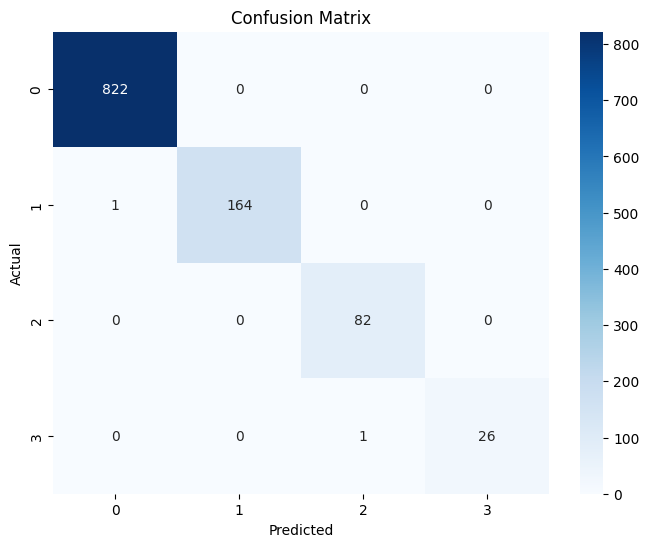

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       822
           1       1.00      0.99      1.00       165
           2       0.99      1.00      0.99        82
           3       1.00      0.96      0.98        27

    accuracy                           1.00      1096
   macro avg       1.00      0.99      0.99      1096
weighted avg       1.00      1.00      1.00      1096



In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
              feature  importance
13        Flood_Index    0.280758
7        flow_3d_mean    0.182722
0     Daily flow Rate    0.161084
1   Gauge height flow    0.107623
17  Gauge_height_lag1    0.082641
16    Daily_flow_lag1    0.080683
8        flow_7d_mean    0.044544
4          sm_10_40cm    0.016508
11           soil_avg    0.012472
9        flow_diff_1d    0.009027


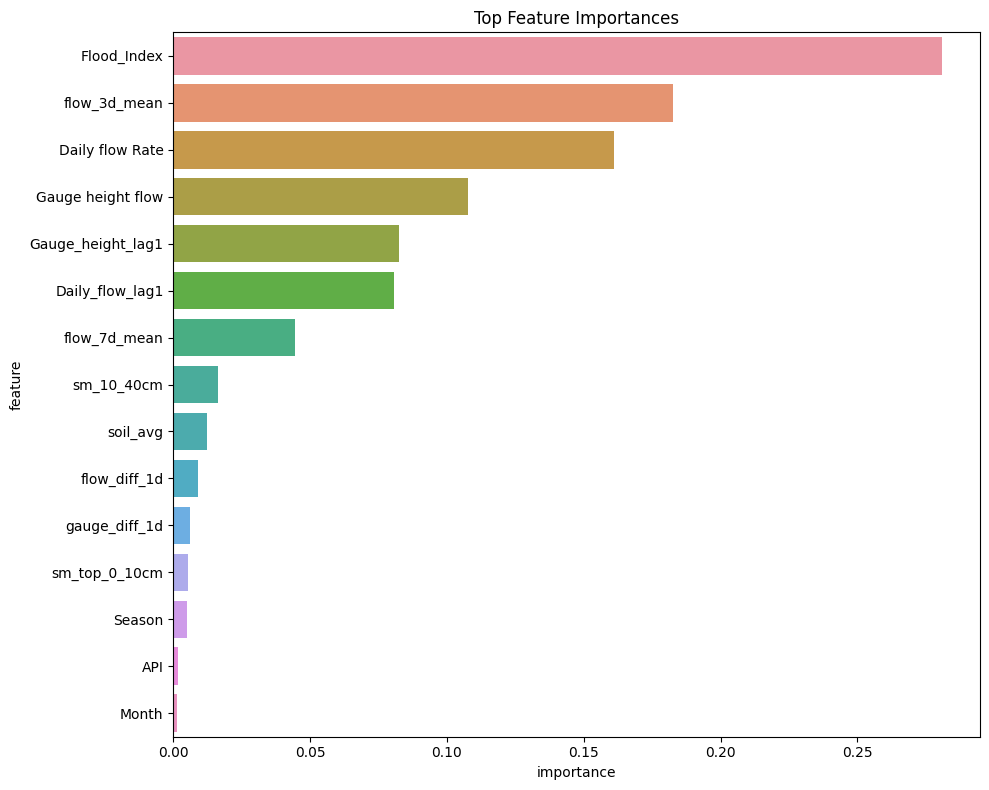

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
print("\n🔍 Feature Importance Insights:")
top_features = feature_importance.head(10)
for _, row in top_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


🔍 Feature Importance Insights:
Flood_Index: 0.2808
flow_3d_mean: 0.1827
Daily flow Rate: 0.1611
Gauge height flow: 0.1076
Gauge_height_lag1: 0.0826
Daily_flow_lag1: 0.0807
flow_7d_mean: 0.0445
sm_10_40cm: 0.0165
soil_avg: 0.0125
flow_diff_1d: 0.0090


In [ ]:
# Check if model is too perfect (potential data leakage)
train_score = best_model.score(X_train_scaled, y_train)
test_score = best_model.score(X_test_scaled, y_test)

print(f"Train Score: {train_score:.3f}")
print(f"Test Score: {test_score:.3f}")
print(f"Gap: {train_score - test_score:.3f}")

# If gap > 0.05, potential overfitting

Train Score: 1.000
Test Score: 0.998
Gap: 0.002
